# Solving a discrete boundary-value problem in scipy

TAGS: Ordinary differential equations

AUTHORS: Nikolay Mayorov

## Mathematical formulation

We consider a nonlinear elliptic boundary-value problem in a square domain $\Omega = [0, 1] \times [0, 1]$:
$$
\Delta u + k f(u) = 0 \\
u = 0 \text{ on } \partial \Omega
$$

Here $u = u(x,y)$ is an unknown function, $\Delta$ is [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator), $k$ is some constant and $f(u)$ is a given function.

A usual computational approach to such problems is discretization. We use a uniform grid with some step $h$, and define $u_{i, j} = u(i h , jh)$. By approximating Laplace operator using [5-point finite difference](https://en.wikipedia.org/wiki/Discrete_Laplace_operator) we get a system of equations in the form:
$$
u_{i - 1, j} + u_{i + 1, j} + u_{i, j - 1} + u_{i, j + 1} - 4 u_{i,j} + c f(u_{i,j}) = 0 \\
u_{i, j} = 0 \text{ on } \partial \Omega
$$

Here $c = k h^2$.

## Defining the problem for scipy

From now on we focus on the discrete version and consider a grid with $n = 100$ ticks for each dimension and set $c = 1$ and $f(u) = u^3$.

In [1]:
n = 100
c = 1

In [2]:
def f(u):
    return u**3

def f_prime(u):
    return 3 * u**2

To solve the system of equations we will use `scipy.optimize.least_squares`.

We define a function computing left-hand sides of each equation. Note that we assume values on the boundary to be fixed at zeros and don't change them during optimization.

In [3]:
import numpy as np

def fun(u, n, f, f_prime, c, **kwargs):        
    v = np.zeros((n + 2, n + 2))
    u = u.reshape((n, n))
    v[1:-1, 1:-1] = u
    y = v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2] + v[1:-1, 2:] - 4 * u + c * f(u)
    return y.ravel()

It is always recommened to provide analytical Jacobian if possible. In our problem we have $n^2=10000$ equations and variables, but each equation depends only on few variables, thus we should compute Jacobian in a sparse format.

It is convenient to precompute indices of rows and columns of nonzero elements in Jacobian. We definte the corresponding function:

In [4]:
def compute_jac_indices(n):        
    i = np.arange(n)
    jj, ii = np.meshgrid(i, i)
    
    ii = ii.ravel()
    jj = jj.ravel()
    
    ij = np.arange(n**2)
    
    jac_rows = [ij]
    jac_cols = [ij]
        
    mask = ii > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - n)
        
    mask = ii < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + n)    
    
    mask = jj > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - 1)    
    
    mask = jj < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + 1)
    
    return np.hstack(jac_rows), np.hstack(jac_cols)    

After that computing Jacobian in `coo_matrix` format is simple:

In [5]:
jac_rows, jac_cols = compute_jac_indices(n)

In [6]:
from scipy.sparse import coo_matrix

def jac(u, n, f, f_prime, c, jac_rows=None, jac_cols=None):
    jac_values = np.ones_like(jac_cols, dtype=float)    
    jac_values[:n**2] = -4 + c * f_prime(u)    
    return coo_matrix((jac_values, (jac_rows, jac_cols)), shape=(n**2, n**2))

## Solving the problem

Without any insight to the problem we set all the values to 0.5 initially. Note, that it is not guranteed that the given continuous or discrete problems have a unique solution.

In [7]:
u0 = np.ones(n**2) * 0.5

Precompute rows and columns of nonzero elements in Jacobian:

In [8]:
jac_rows, jac_cols = compute_jac_indices(n)

Now we are ready to run the optimization. The first solution will be computed without imposing any bounds on the variables.

In [9]:
%%time
from scipy.optimize import least_squares

res_1 = least_squares(fun, u0, jac=jac, gtol=1e-3, args=(n, f, f_prime, c), kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols}, verbose=1)
res_1

`gtol` termination condition is satisfied.
Function evaluations 112, initial cost 1.0412e+02, final cost 4.0499e-03, first-order optimality 6.30e-04.
CPU times: user 1min 9s, sys: 1min 31s, total: 2min 41s
Wall time: 17.7 s


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.232e-04 -2.411e-04 ... -2.411e-04 -1.232e-04]
           x: [ 5.556e-03  1.105e-02 ...  1.105e-02  5.557e-03]
        cost: 0.004049882191035165
         jac:   (0, 0)	-3.9999074026505026
                (0, 1)	1.0
                (0, 100)	1.0
                (1, 0)	1.0
                (1, 1)	-3.999633724769813
                (1, 2)	1.0
                (1, 101)	1.0
                (2, 1)	1.0
                (2, 2)	-3.9991928683849354
                (2, 3)	1.0
                (2, 102)	1.0
                (3, 2)	1.0
                (3, 3)	-3.9986123722989286
                (3, 4)	1.0
                (3, 103)	1.0
                (4, 3)	1.0
                (4, 4)	-3.997937450299092
                (4, 5)	1.0
                (4, 104)	1.0
                (5, 4)	1.0
                (5, 5)	-3.9972331304658493
                (5, 6)	1.0
                (5, 105)	1.0
                (6

Below we visualize the first solution. The left plot shows the flatten solution, the middle plot shows how the solution looks in the square domain, and the right plot shows final residuals in each node.

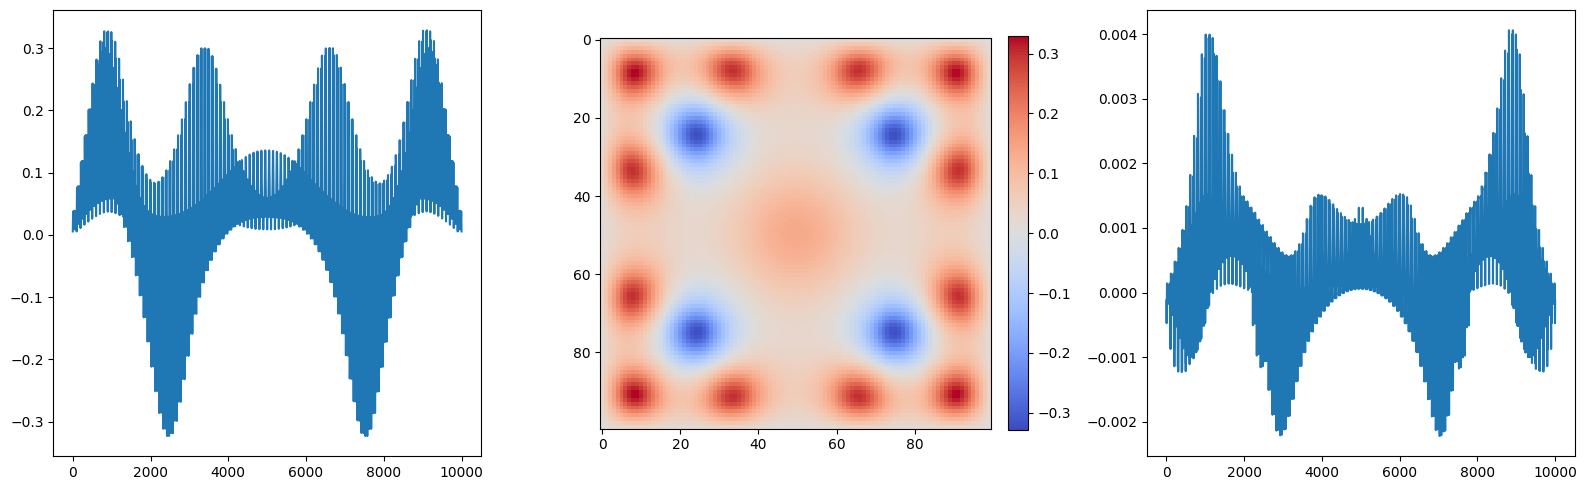

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(132)
plt.imshow(res_1.x.reshape((n, n)), cmap='coolwarm', vmin=-max(abs(res_1.x)), vmax=max(abs(res_1.x)))
plt.colorbar(use_gridspec=True, fraction=0.046, pad=0.04)
plt.subplot(131)
plt.plot(res_1.x)
plt.subplot(133)
plt.plot(res_1.fun)
plt.tight_layout()

It is possible that some physical considerations require that the solution must be non-negative everywhere. We can achieve that by specifying bounds to the solver:

In [11]:
%%time
res_2 = least_squares(fun, u0, jac=jac, bounds=(0, np.inf), gtol=1e-3,
                      args=(n, f, f_prime, c), kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols}, verbose=1)

`gtol` termination condition is satisfied.
Function evaluations 34, initial cost 1.0412e+02, final cost 4.1161e-02, first-order optimality 9.31e-04.
CPU times: user 34.8 s, sys: 35.5 s, total: 1min 10s
Wall time: 7.9 s


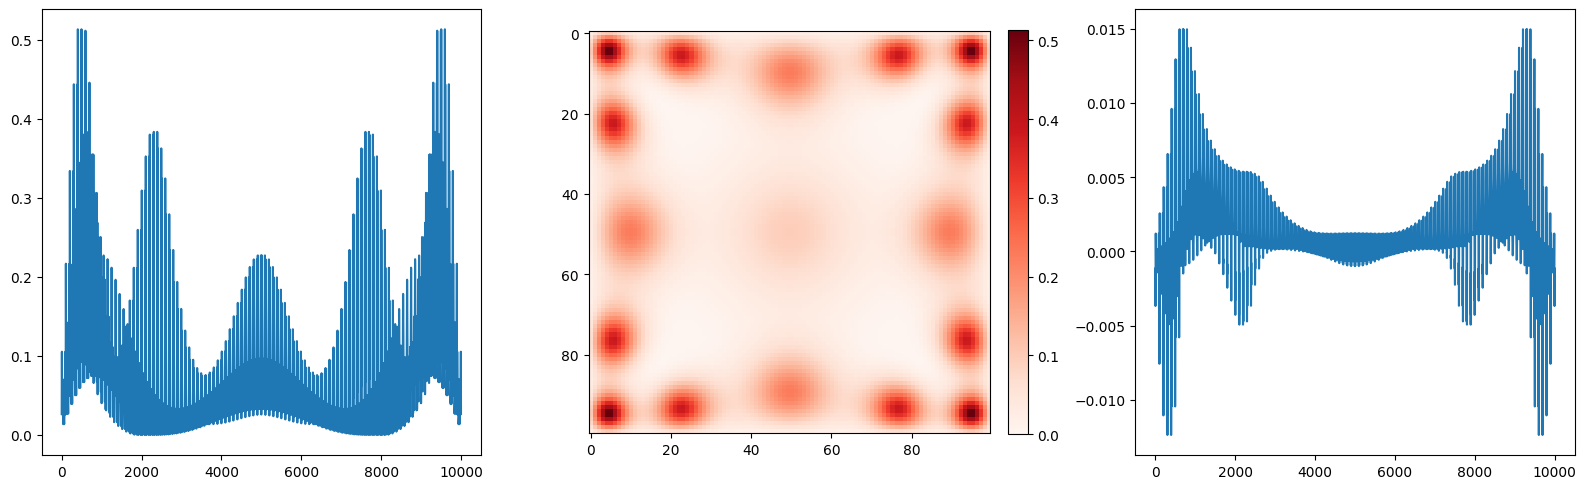

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(132)
plt.imshow(res_2.x.reshape((n, n)), cmap='Reds')
plt.colorbar(use_gridspec=True, fraction=0.046, pad=0.04)
plt.subplot(131)
plt.plot(res_2.x)
plt.subplot(133)
plt.plot(res_2.fun)
plt.tight_layout()

We see that setting a lower bound allowed us to find a different non-negative solution.

You can try running optimization from different starting points, using different bounds or changing $c$ and $f(u)$, and see how it affects the result from `least_squares` solver.